<a href="https://colab.research.google.com/github/edward-000000/Actividades-senati/blob/main/identificar_ropa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Sofware reconocimiento de ropa: Calzado, pantalon, accesorios, etc

Importando librerias

In [50]:
import tensorflow as tf
import tensorflow_datasets as tfds

CARGAR ARCHIVOS

In [51]:
#Descargar set de datos de Fashion MNIST de Zalando
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [ ]:
#Imprimir los metadatos para ver que trae el set
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir=PosixGPath('/tmp/tmpoijkkawptfds'),
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao an

In [52]:
#Obtenemos en variables separadas los datos de entrenamiento (60k) y pruebas (10k)
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

Etiquetar nombrar categorias de ropa

In [53]:
#Etiquetas de las 10 categorias posibles
nombres_clases = ['Camiseta/polo', 'Pantalón', 'Suéter', 'Vestido', 'Abrigo', 'Sandalia', 'Camisa', 'Zapatilla', 'Bolso', 'Botín']
print(nombres_clases)

['Camiseta/polo', 'Pantalón', 'Suéter', 'Vestido', 'Abrigo', 'Sandalia', 'Camisa', 'Zapatilla', 'Bolso', 'Botín']


In [54]:
nombres_clases

['Camiseta/polo',
 'Pantalón',
 'Suéter',
 'Vestido',
 'Abrigo',
 'Sandalia',
 'Camisa',
 'Zapatilla',
 'Bolso',
 'Botín']

Normalizacion y cache

In [55]:
#Funcion de normalizacion para los datos (Pasar de 0-255 a 0-1)
#Hace que la red aprenda mejor y mas rapido
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aqui lo pasa de 0-255 a 0-1
  return imagenes, etiquetas

#Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()

Mostrar la primera imagen de los datos de entrenamiento

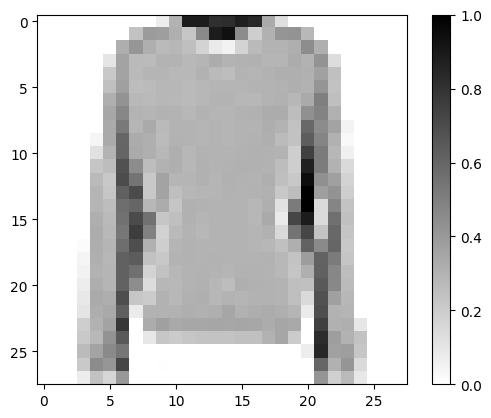

In [56]:
#Mostrar una imagen de los datos de pruebas, de momento mostremos la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28)) #Redimensionar, cosas de tensores, lo veremos despues

import matplotlib.pyplot as plt

#Dibujar dibujar
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Mostrar las múltiples imágenes

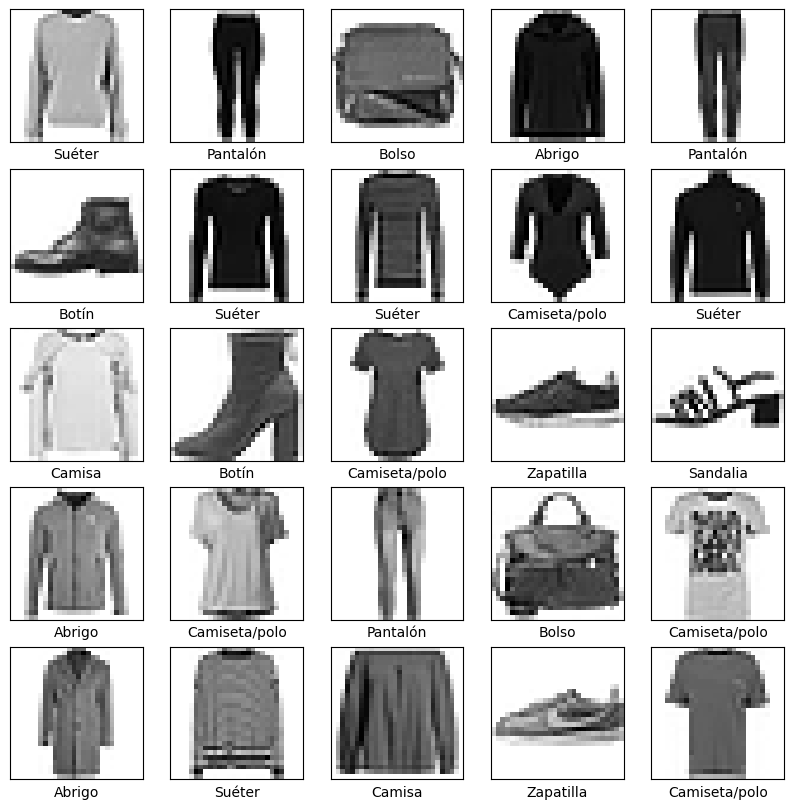

In [57]:
#Dibujar mas
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

Crear el modelo de red neuronal

In [58]:
#Crear el modelo
modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),  # Imagen en blanco y negro
    tf.keras.layers.Dense(50, activation=tf.nn.relu),  # Capa oculta con 50 neuronas y ReLU
    tf.keras.layers.Dense(50, activation=tf.nn.relu),  # Otra capa oculta con 50 neuronas y ReLU
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)  # Capa de salida para clasificar en 10 clases
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compilar el modelo neuronl

In [59]:
# Compilar el modelo
modelo.compile(
    optimizer='adam',  # Optimizador Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Pérdida para clasificación categórica
    metrics=['accuracy']  # Métrica de precisión
)

Numero de ejemplos de entrenamiento y prueba

In [60]:
#Los numeros de datos en entrenamiento y pruebas (60k y 10k)
num_entrenamiento = metadatos.splits["train"].num_examples
num_pruebas = metadatos.splits["test"].num_examples

In [61]:
print(num_entrenamiento)
print(num_pruebas)

60000
10000


Trabajo por lotes (Batching) y mezcla aleatoria (Shuffling)

In [62]:
#El trabajo por lotes permite que entrenamientos con gran cantidad de datos se haga de manera mas eficiente
TAMANO_LOTE = 32

#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
#no se vaya a aprender el orden de las cosas
#Entrenamiento del modelo
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

Visualizar la magnitud de pérdida a lo largo de las épocas

In [63]:
import math

#Entrenar
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch= math.ceil(num_entrenamiento/TAMANO_LOTE))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7631 - loss: 0.6889
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8610 - loss: 0.3869
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8700 - loss: 0.3477
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8769 - loss: 0.3337
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8844 - loss: 0.3109


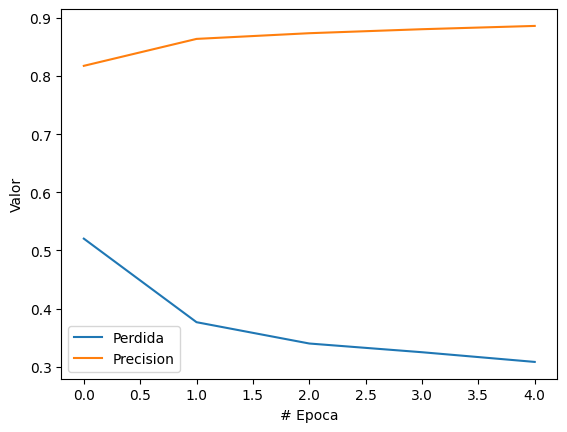

In [64]:
plt.plot(historial.history["loss"], label="Perdida")
plt.plot(historial.history["accuracy"], label="Precision")
plt.xlabel("# Epoca")
plt.ylabel("Valor")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


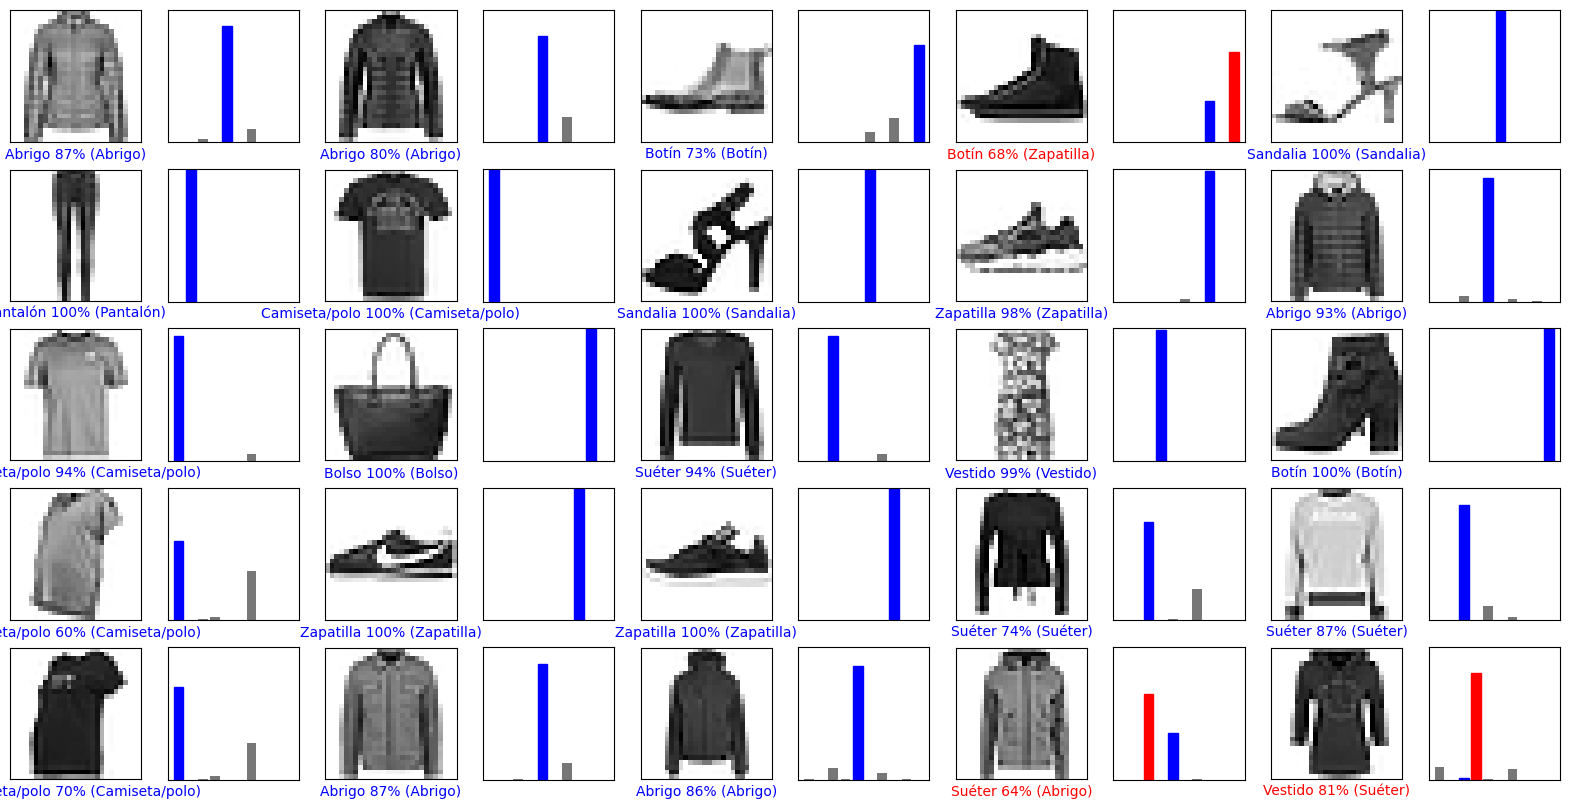

In [65]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')

filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


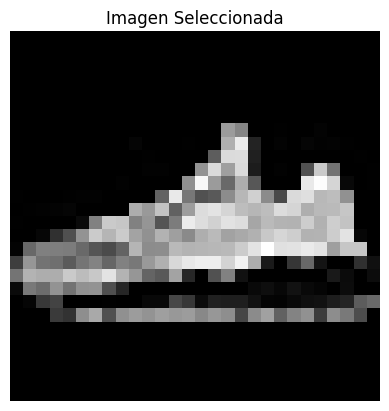

Prediccion: Zapatilla


In [66]:
#Probar una imagen suelta
# Seleccionar una imagen
imagen = imagenes_prueba[8]
imagen = np.array([imagen])

# Predecir
prediccion = modelo.predict(imagen)

# Visualizar
plt.imshow(imagen[0], cmap='gray')
plt.title("Imagen Seleccionada")
plt.axis('off')
plt.show()

# Imprimir predicción
print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])

Tamaño de la imagen cargada: (1, 28, 28, 1)
Forma esperada por el modelo: (None, 28, 28, 1)
Haciendo predicción...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


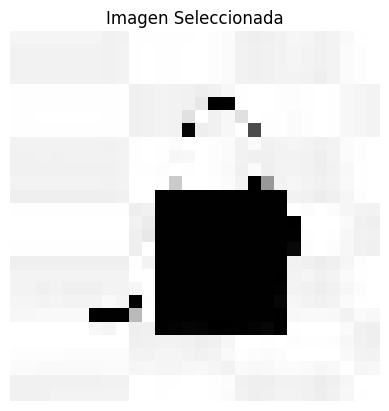

Predicción: Bolso


In [73]:
import tkinter as tk
from tkinter import filedialog
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Ruta de la imagen en el sistema de archivos de Colab
ruta_imagen = 'OIP.jpeg'
# Función para cargar una imagen desde una ruta específica
def cargar_imagen(ruta):
    try:
        # Cargar la imagen y cambiar el tamaño a 28x28 píxeles en escala de grises
        img = image.load_img(ruta, color_mode="grayscale", target_size=(28, 28))
        img = image.img_to_array(img)  # Convertir a array de Numpy
        img = np.expand_dims(img, axis=0)  # Añadir dimensión para el lote
        img /= 255.0  # Normalizar los valores de la imagen
        print(f"Tamaño de la imagen cargada: {img.shape}")
        return img
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None

# Función para predecir y visualizar la imagen
def predecir_y_visualizar_desde_ruta():
    imagen = cargar_imagen(ruta_imagen)  # Cargar la imagen desde la ruta

    if imagen is not None:
        try:
            # Verificar la forma de entrada del modelo
            input_shape = modelo.input_shape  # Asegúrate de que el modelo está cargado
            print(f"Forma esperada por el modelo: {input_shape}")

            # Hacer la predicción
            print("Haciendo predicción...")
            prediccion = modelo.predict(imagen)

            # Visualizar la imagen
            plt.imshow(imagen[0].squeeze(), cmap='gray')
            plt.title("Imagen Seleccionada")
            plt.axis('off')
            plt.show()

            # Mostrar predicción
            print("Predicción: " + nombres_clases[np.argmax(prediccion[0])])

        except Exception as e:
            print(f"Error al hacer la predicción: {e}")

# Llamar a la función para cargar la imagen y predecir
predecir_y_visualizar_desde_ruta()

In [75]:
#Exportacion del modelo a h5
modelo.save('modelo_exportado.h5')

In [76]:
#Veamos si si creo la carpeta
!ls

modelo_exportado.h5  OIP.jpeg  R.jpeg  sample_data  tfjs_target_dir


In [77]:
#Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
!pip install tensorflowjs

In [78]:
#Convertir el archivo h5 a formato de tensorflowjs
!mkdir archivo_salida

In [79]:

!tensorflowjs_converter --input_format keras modelo_exportado.h5 archivo_salida

2024-09-20 15:56:51.127859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 15:56:51.155952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 15:56:51.163821: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 15:56:52.908456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file


In [81]:
#Veamos el contenido de la carpeta
!ls archivo_salida

group1-shard1of1.bin  model.json
